In [2]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')


%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py
%run decomposition.py

/Users/akbaskind/Documents/Python Scripts/phyto


In [3]:
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [4]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

In [5]:
MetData_PLT = PLT.get_buoy('2022-01-01', '2023-07-01','PLT','MetData')
met_PLT = pd.DataFrame(MetData_PLT) 
met_PLT = met_PLT.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)
met_PLT

,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPrecipitation,DateTime
0,1.176740,238.703,2.191290,222.4200,8.6,0.0,2022-01-01 00:00:00
1,0.982541,229.899,2.133050,220.3470,8.4,0.0,2022-01-01 00:10:00
2,0.321709,228.680,0.776346,231.6590,8.4,0.0,2022-01-01 00:20:00
3,0.650487,192.874,0.987254,179.1100,8.6,0.0,2022-01-01 00:30:00
4,0.277924,359.750,1.629940,17.6544,7.9,0.0,2022-01-01 00:40:00
...,...,...,...,...,...,...,...
72710,2.191040,194.006,3.103230,192.3210,20.5,0.0,2023-06-30 23:10:00
72711,2.307460,197.082,2.879900,188.3290,20.6,0.0,2023-06-30 23:20:00
72712,2.207490,206.130,2.892030,220.3490,20.7,0.0,2023-06-30 23:30:00
72713,2.980040,218.227,3.952450,224.5870,20.8,0.0,2023-06-30 23:40:00


In [6]:
for k in met_PLT.keys():
    if k == 'DateTime':
        met_PLT[k] = pd.to_datetime(met_PLT[k], format = '%Y-%m-%D %H:%M:%S')

In [7]:
hydrocat620 = pd.merge_asof(hydrocat620, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat620 = hydrocat620.reset_index(drop=True)
hydrocat620

,DateTime,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPrecipitation
0,2022-01-04 09:31:15.400,6.5078,30.7871,9.592,7.934479,7.478,7.934479,7.797240,4.17783,312.00800,5.73720,304.4380,-5.4,0.00
1,2022-01-04 10:46:15.400,6.3631,30.8278,9.663,7.934814,1.844,7.934814,7.795139,3.36956,344.56700,6.48919,334.8180,-4.1,0.00
2,2022-01-04 11:01:15.200,6.3063,30.7459,9.633,7.934773,2.373,7.934773,7.794166,3.35262,351.26400,6.43988,346.6590,-3.8,0.00
3,2022-01-04 11:16:15.200,6.2367,30.7015,9.680,7.934821,3.158,7.934821,7.793057,3.26155,2.19125,4.99753,355.2650,-3.7,0.00
4,2022-01-04 11:31:15.200,6.2593,30.6492,9.698,7.924688,2.170,7.924688,7.783583,2.11043,5.63873,3.85521,10.9126,-3.4,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33677,2023-04-30 22:46:29.000,11.7928,28.4188,8.547,7.971222,0.021,7.971222,7.920264,9.32241,147.82900,14.04750,148.5850,14.4,2.00
33678,2023-04-30 23:01:29.000,11.7991,28.4178,8.472,7.961210,0.020,7.961210,7.910442,9.79472,139.29300,14.15330,135.4380,14.5,1.04
33679,2023-04-30 23:16:29.000,11.8380,28.3284,8.471,7.971013,0.021,7.971013,7.920790,9.63465,139.50900,13.63680,149.3620,14.5,0.72
33680,2023-04-30 23:31:29.000,11.9170,28.1962,8.406,7.970686,0.020,7.970686,7.921743,9.89771,137.25500,15.49660,148.8290,14.9,2.80


In [8]:
#QP
QP = pd.merge_asof(QP, met_PLT, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
QP = QP.reset_index(drop=True)

In [9]:
## MET GB
MetData_GB = PLT.get_buoy('2022-01-01', '2023-07-01','GB','MetData')
met_GB = pd.DataFrame(MetData_GB) 
met_GB = met_GB.drop(['TmStamp','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity'], axis=1)
met_GB

,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPrecipitation,DateTime
0,0.936771,349.553000,1.65960,322.691,7.1,0.0,2022-01-01 00:00:00
1,1.127380,336.847000,1.77327,324.336,7.0,0.0,2022-01-01 00:10:00
2,1.001410,0.220732,1.38000,359.000,7.0,0.0,2022-01-01 00:20:00
3,1.506670,0.166002,1.73923,358.337,6.9,0.0,2022-01-01 00:30:00
4,1.295750,4.968490,1.73643,357.660,6.9,0.0,2022-01-01 00:40:00
...,...,...,...,...,...,...,...
77244,3.992220,205.859000,5.15074,206.515,21.0,0.0,2023-06-30 23:10:00
77245,3.558400,211.066000,5.59082,194.977,21.0,0.0,2023-06-30 23:20:00
77246,3.462170,219.634000,4.30473,219.243,21.1,0.0,2023-06-30 23:30:00
77247,3.666640,219.962000,4.43232,210.267,21.0,0.0,2023-06-30 23:40:00


In [10]:
for k in met_GB.keys():
    if k == 'DateTime':
        met_GB[k] = pd.to_datetime(met_GB[k], format = '%Y-%m-%D %H:%M:%S')

In [11]:
hydrocat720 = pd.merge_asof(hydrocat720, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat720 = hydrocat720.reset_index(drop=True)

In [12]:
## GB to MV
MV = pd.merge_asof(MV, met_GB, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
MV = MV.reset_index(drop=True)

## decomposition

In [31]:
[comp620, std620] = decomposition.decomposition(hydrocat620, 'M', location = 'PLT')
[comp720, std720] = decomposition.decomposition(hydrocat720, 'M', location = 'GB')
[compMV, stdMV] = decomposition.decomposition(MV, 'M', location = 'GB')
[compQP, stdQP] = decomposition.decomposition(QP, 'M', location = 'PLT')

In [20]:
hotpink = '#ff0066'
purple = 'purple'
teal = 'turquoise'
violet = '#cc99ff'
green = '#DFFF00'
tan ='#ffe5b4'
orange = '#ffbd21'
sea = '#00cc66'
yellow = '#FFDF00' 
red = 'red'
rose ='#ff5349'
blue ='blue' 
pink = 'pink'
interval =1

## hydrocat620

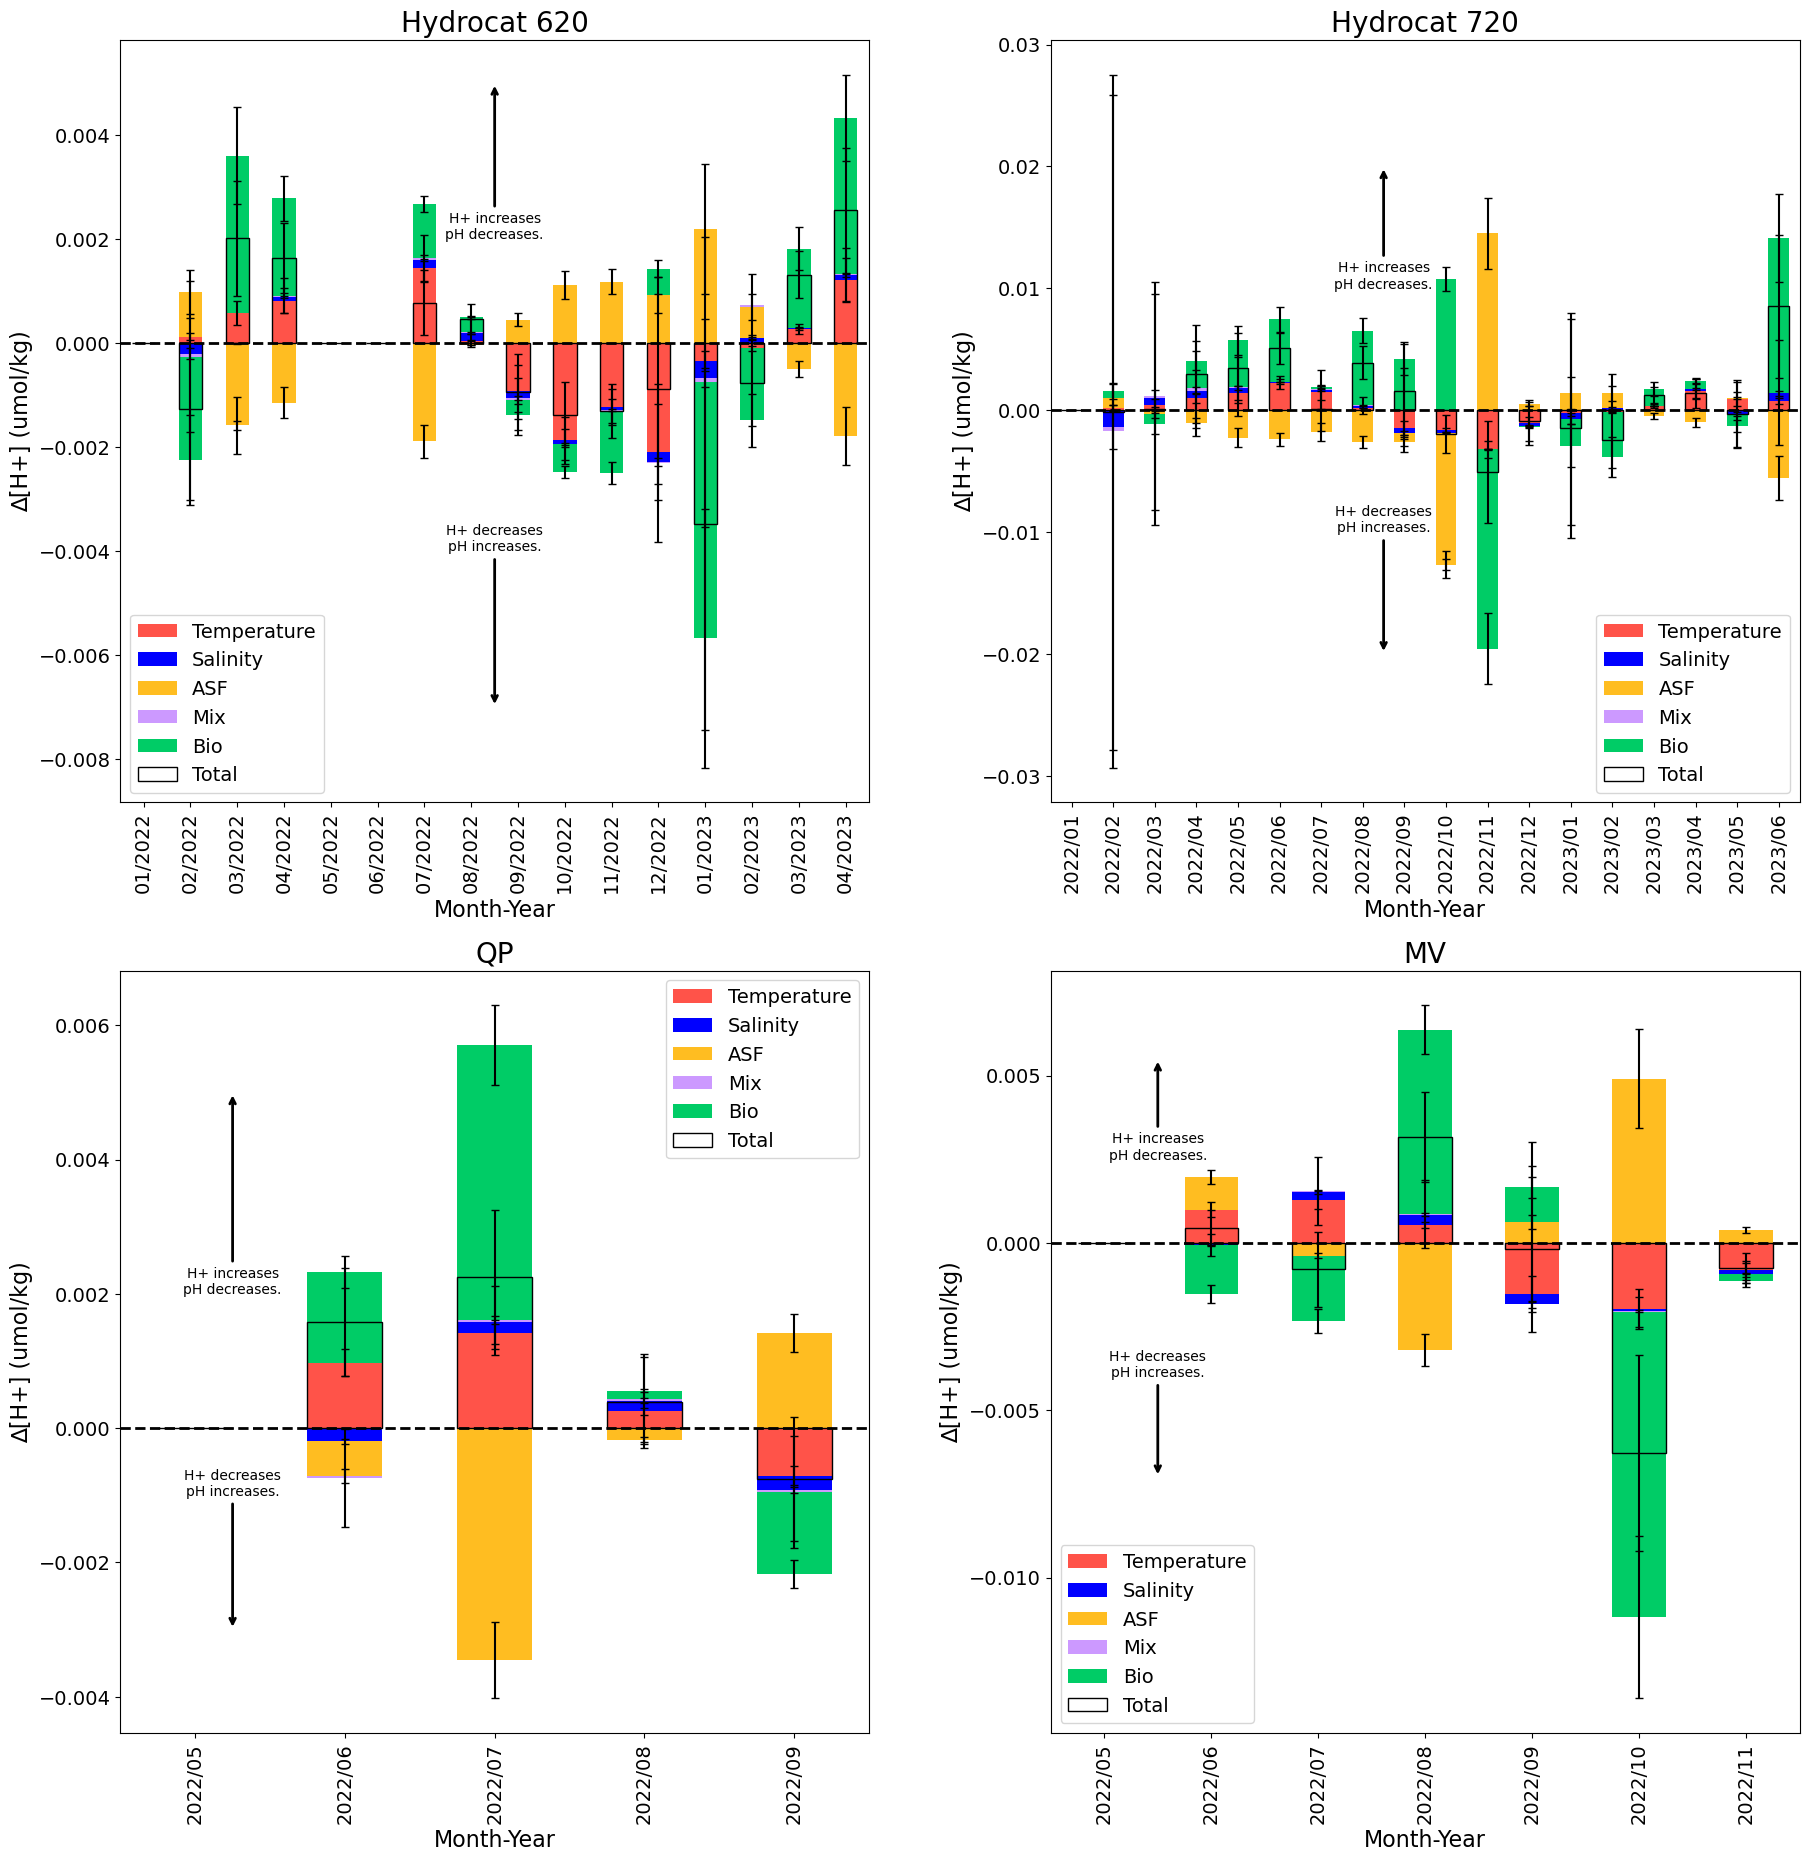

In [44]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
fig.tight_layout(pad=10.0)
axarr = axarr.flatten()

ax = axarr[0]
df = comp620
dt = std620
title = 'Hydrocat 620'

df_ = pd.DataFrame({ 'Temperature': df['Temperature'],
                     'Salinity': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'Temperature': dt['Temperature'],
                     'Salinity': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['Temperature','Salinity','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [rose,blue,orange,violet,sea], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)


ax.set_xticklabels(df.index.strftime('%m/%Y'), fontsize = 14);
ax.tick_params('x',labelsize = 14, labelrotation = 90)
ax.tick_params('y',labelsize = 14)
ax.annotate('H+ increases\npH decreases.',
             xy=(7.5,0.005),
             xytext=(7.5, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(7.5,-0.007),
             xytext=(7.5, -0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

# ax.text(datetime(2022, 1,5), 0.004, 'Temperature has a \npositive effect \non pH')
# ax.text(datetime(2022, 1, 5), -0.004, 'Temperature has a \nnegative effect \non pH')
# ax.text(start_date, 0.004, 'npositive effect' )
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)

ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 20)

ax =axarr[1]
df = comp720
dt = std720
title = 'Hydrocat 720'

df_ = pd.DataFrame({ 'Temperature': df['Temperature'],
                     'Salinity': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'Temperature': dt['Temperature'],
                     'Salinity': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['Temperature','Salinity','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [rose,blue,orange,violet,sea], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)
# ax.set_xlim(start_date, end_date)
DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))  # Set the positions of the tick marks
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax.annotate('H+ increases\npH decreases.',
             xy=(7.5,0.02),
             xytext=(7.5, 0.01), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(7.5,-0.02),
             xytext=(7.5, -0.01), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))
ax.set_xticklabels(df.index.strftime('%Y/%m'), fontsize = 14);
ax.tick_params('x',labelsize = 14, labelrotation = 90)
ax.tick_params('y',labelsize = 14)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)
# ax.set_xlim(start_date, end_date)
ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 20)

ax = axarr[2]
df = compQP
dt = stdQP
title = 'QP'

df_ = pd.DataFrame({ 'Temperature': df['Temperature'],
                     'Salinity': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'Temperature': dt['Temperature'],
                     'Salinity': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['Temperature','Salinity','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color = [rose,blue,orange,violet,sea], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)

ax.annotate('H+ increases\npH decreases.',
             xy=(0.25,0.005),
             xytext=(0.25, 0.002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(0.25,-0.003),
             xytext=(0.25, -0.001), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))  # Set the positions of the tick marks
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xticklabels(df.index.strftime('%Y/%m'), fontsize = 14);
ax.tick_params('x',labelsize = 14, labelrotation = 90)
ax.tick_params('y',labelsize = 14)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)
# ax.set_xlim(start_date, end_date)
ax.legend(fontsize = 14)
ax.set_title(title, fontsize = 20)


ax = axarr[3]
df = compMV
dt = stdMV
title = 'MV'

df_ = pd.DataFrame({ 'Temperature': df['Temperature'],
                     'Salinity': df['Salinity'],
                     'ASF': df['DIC air sea flux'],
                     'Mix': df['Total mixing'],
                     'Bio': df['Total bio'],
                     'Total': df['Total'],
                     'DateTime': df['DateTime']})
DF = pd.DataFrame({ 'Total': df['Total']}, index=df['DateTime'])
err_ = pd.DataFrame({'Temperature': dt['Temperature'],
                     'Salinity': dt['Salinity'],
                     'ASF': dt['DIC ASF'],
                     'Mix': dt['Total mixing'],
                     'Bio': dt['Total bio']}, index=df['DateTime'])
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
df_[['Temperature','Salinity','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_, color =[rose,blue,orange,violet,sea], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)
DF.plot(kind='bar',yerr = dt['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)
ax.annotate('H+ increases\npH decreases.',
             xy=(0.5,0.0055),
             xytext=(0.5, 0.0025), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(0.5,-0.007),
             xytext=(0.5, -0.004), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))  # Set the positions of the tick marks
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xticklabels(df.index.strftime('%Y/%m'), fontsize = 14);
ax.tick_params('x',labelsize = 14, labelrotation = 90)
ax.tick_params('y',labelsize = 14)
ax.set_ylabel('∆[H+] (umol/kg)', fontsize = 16)
ax.set_xlabel('Month-Year', fontsize = 16)
# ax.set_xlim(start_date, end_date)
ax.legend(loc='lower left',fontsize = 14)
ax.set_title(title, fontsize = 20)
# ax.set_xlim(start_date, end_date)

fig.savefig('/Users/akbaskind/Desktop/ALL_components.png', bbox_inches='tight')

# By DAY abby pls help sorry i didn't it you up sooner I thought I was capable lmfaoo 

You ARE capable! So the way I wrote this function, if you're going to break it down by day, it is easiest to reduce your dataset to the time period you are interested in prior to running `decomposition()`.

So let's start by picking out a smaller dataset. It looks like you want to look about the first couple weeks of February. Let's make some datasets of hydrocat620, hydrocat720, MV, and QP that *only* have the first couple weeks of february.

In [14]:
start_date = pd.to_datetime('2023-02-04')
end_date = pd.to_datetime('2023-02-12')

# Hydrocat 620
hydro620_FEB = hydrocat620.where(hydrocat620['DateTime'] >= start_date).where(hydrocat620['DateTime'] <= end_date).dropna()
hydro620_FEB = hydro620_FEB.reset_index(drop=True)

# Hydrocat 720
hydro720_FEB = hydrocat720.where(hydrocat720['DateTime'] >= start_date).where(hydrocat720['DateTime'] <= end_date).dropna()
hydro720_FEB = hydro720_FEB.reset_index(drop=True)

# QP 
QP_FEB = QP.where(QP['DateTime'] >= start_date).where(QP['DateTime'] <= end_date).dropna()
QP_FEB = QP_FEB.reset_index(drop=True)

# MV
MV_FEB = MV.where(MV['DateTime'] >= start_date).where(MV['DateTime'] <= end_date).dropna()
MV_FEB = MV_FEB.reset_index(drop=True)

In [52]:
start_date = pd.to_datetime('2022-12-22')
end_date = pd.to_datetime('2022-12-28')

# Hydrocat 620
hydro620_DEC = hydrocat620.where(hydrocat620['DateTime'] >= start_date).where(hydrocat620['DateTime'] <= end_date).dropna()
hydro620_DEC = hydro620_DEC.reset_index(drop=True)

# Hydrocat 720
hydro720_DEC = hydrocat720.where(hydrocat720['DateTime'] >= start_date).where(hydrocat720['DateTime'] <= end_date).dropna()
hydro720_DEC = hydro720_DEC.reset_index(drop=True)


Note that QP and MV do not have Feburary dates, so we will not run decomposition on them.

(2.0, 9.0)

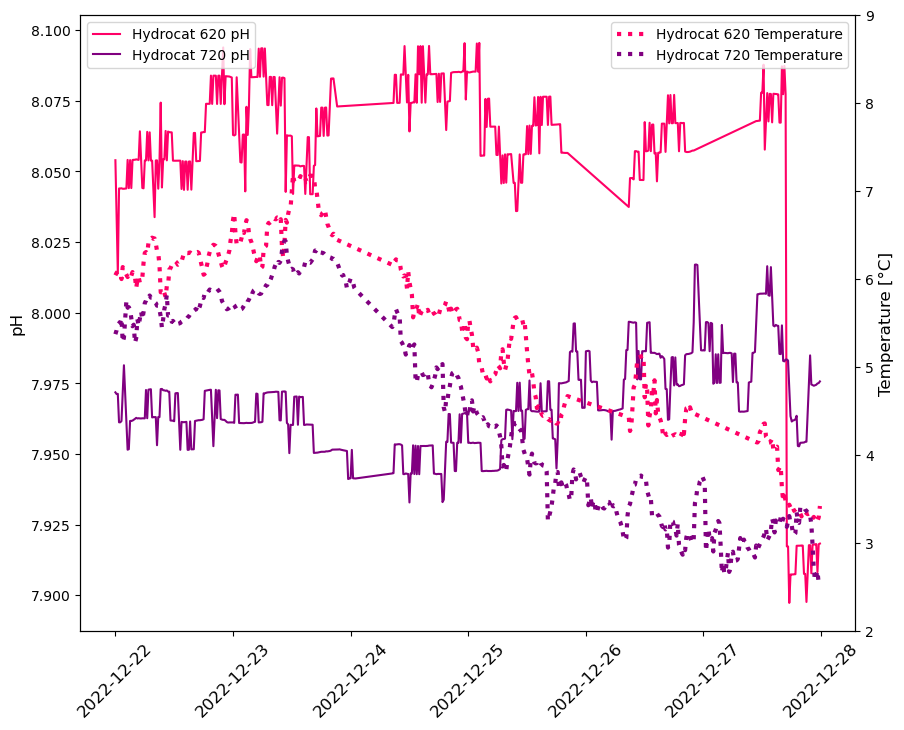

In [80]:
fig, ax = plt.subplots(figsize = [10,8])

ax.plot(hydro620_DEC['DateTime'], hydro620_DEC['pH final'], color = hotpink, label = 'Hydrocat 620 pH')
ax.plot(hydro720_DEC['DateTime'], hydro720_DEC['pH final'], color = purple, label = 'Hydrocat 720 pH')
ax.tick_params('x',labelsize = 12, labelrotation = 45)
ax.legend(loc = 'upper left')
ax.set_ylabel('pH', fontsize = 12)
# ax.set_ylim([7.9,8.125])

ax2 = ax.twinx()
ax2.plot(hydro620_DEC['DateTime'], hydro620_DEC['Temperature [degC]'], color = hotpink, ls = 'dotted', lw = 3,
        label = 'Hydrocat 620 Temperature')
ax2.plot(hydro720_DEC['DateTime'], hydro720_DEC['Temperature [degC]'], color = purple, ls = 'dotted', lw = 3,
        label = 'Hydrocat 720 Temperature')
ax2.legend(loc = 'upper right')
ax2.set_ylabel('Temperature [°C]', fontsize = 12)
ax2.set_ylim([2,9])

(0.0, 5.0)

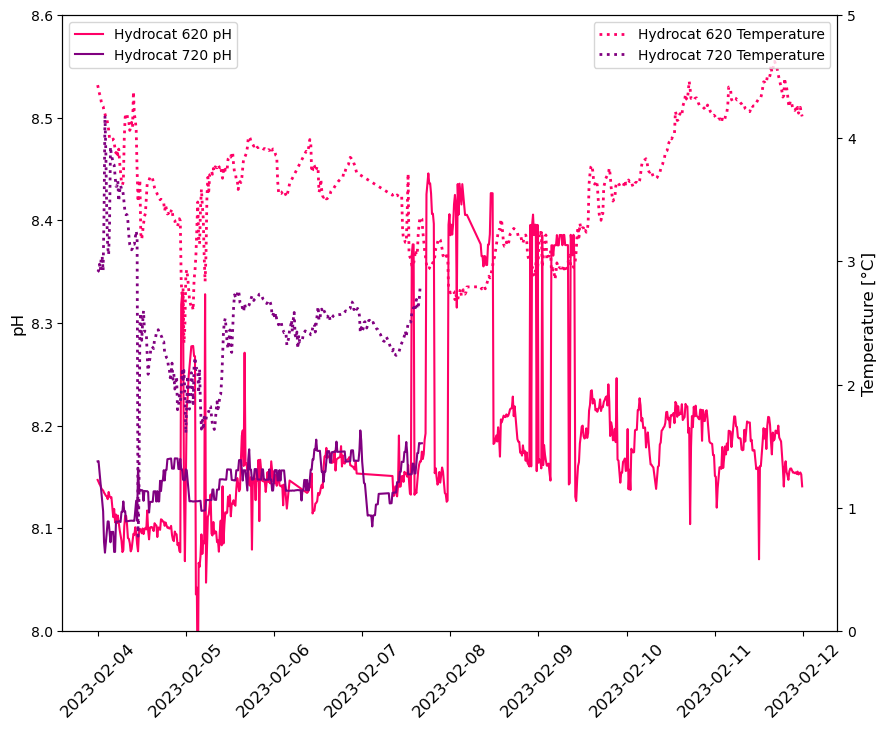

In [88]:
fig, ax = plt.subplots(figsize = [10,8])

ax.plot(hydro620_FEB['DateTime'], hydro620_FEB['pH final'], color = hotpink, label = 'Hydrocat 620 pH')
ax.plot(hydro720_FEB['DateTime'], hydro720_FEB['pH final'], color = purple, label = 'Hydrocat 720 pH')
ax.tick_params('x',labelsize = 12, labelrotation = 45)
ax.legend(loc = 'upper left')
ax.set_ylabel('pH', fontsize = 12)
ax.set_ylim([8,8.6])

ax2 = ax.twinx()
ax2.plot(hydro620_FEB['DateTime'], hydro620_FEB['Temperature [degC]'], color = hotpink, ls = 'dotted', lw = 2,
        label = 'Hydrocat 620 Temperature')
ax2.plot(hydro720_FEB['DateTime'], hydro720_FEB['Temperature [degC]'], color = purple, ls = 'dotted', lw = 2,
        label = 'Hydrocat 720 Temperature')
ax2.legend(loc = 'upper right')
ax2.set_ylabel('Temperature [°C]', fontsize = 12)
ax2.set_ylim([0,5])

In [18]:
[Dcomp620, Dstd620] = decomposition.decomposition(hydro620_FEB, 'D', location = 'PLT')
[Dcomp720, Dstd720] = decomposition.decomposition(hydro720_FEB, 'D', location = 'GB')



Honestly, good for you for trying to debug on your own! I see and commend your efforts.

In [71]:

# Check for missing values in the date range
missing_values = df_D[(df_D['DateTime'] >= start_date) & (df_D['DateTime'] <= end_date)].isnull().any()
print(missing_values)

Temperature    False
Salinity       False
ASF            False
Mix            False
Bio            False
Total          False
DateTime       False
dtype: bool


Text(0, -0.005, 'H+ decreases\npH increases.')

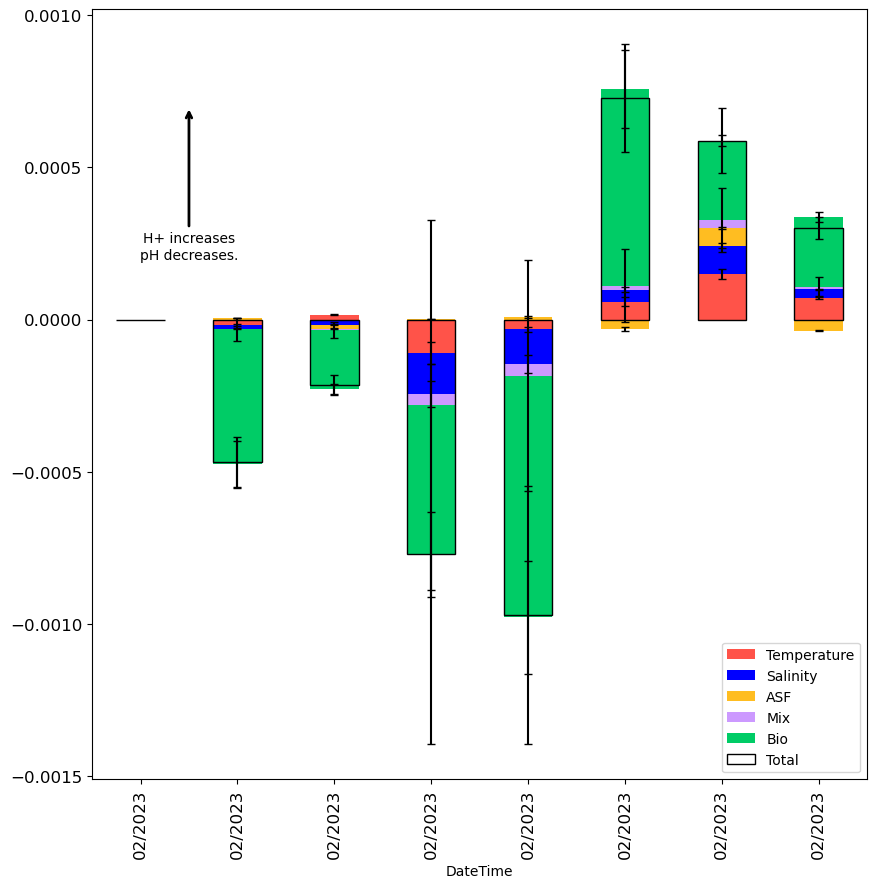

In [30]:
# I am changing the figure size 
fig,ax= plt.subplots(figsize = [10,10])

title = 'Hydrocat 620'
dfD= Dcomp620[(Dcomp620['DateTime'] >= start_date) & (Dcomp620['DateTime'] <= end_date)]
dtD= Dstd620[(Dstd620['DateTime'] >= start_date) & (Dstd620['DateTime'] <= end_date)]
df_D = pd.DataFrame({ 'Temperature': dfD['Temperature'],
                     'Salinity': dfD['Salinity'],
                     'ASF': dfD['DIC air sea flux'],
                     'Mix': dfD['Total mixing'],
                     'Bio': dfD['Total bio'],
                     'Total': dfD['Total'],
                     'DateTime': dfD['DateTime']})

DFd = pd.DataFrame({ 'Total': dfD['Total']}, index=dfD['DateTime'])
err_D = pd.DataFrame({'Temperature': dtD['Temperature'],
                     'Salinity': dtD['Salinity'],
                     'ASF': dtD['DIC ASF'],
                     'Mix': dtD['Total mixing'],
                     'Bio': dtD['Total bio']}, index=dfD['DateTime'])
# ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

df_D[['Temperature','Salinity','ASF','Mix','Bio']].plot(kind='bar',  yerr = err_D, color = [rose,blue,orange,violet,sea], capsize = 3,
         stacked=True, ax = ax, ecolor = 'k', zorder = 0)

DFd.plot(kind='bar',yerr = dtD['Total error'], ax = ax, color = 'none', edgecolor = 'k', capsize = 3)
ax.legend(loc = 'lower right')

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))  # Set the positions of the tick marks
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xticklabels(dfD.index.strftime('%m/%Y'), fontsize = 14)

ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.annotate('H+ increases\npH decreases.',
             xy=(0.5,0.0007),
             xytext=(0.5, 0.0002), horizontalalignment="center",
             arrowprops=dict(arrowstyle='->',lw=2))

ax.annotate('H+ decreases\npH increases.',
             xy=(0,-0.007),
             xytext=(0, -0.005), horizontalalignment="left")



In [74]:
dfD

,DateTime,Temperature,Salinity,TA mixing,TA bio,DIC mixing,DIC_bio,DIC air sea flux,Total bio,Total mixing,Total
DateTime,,,,,,,,,,,
2023-02-04,2023-02-04,-0.000258,0.000257,-0.002900,0.000300,0.002952,0.002085,-0.000241,0.002385,0.000053,0.002196
2023-02-05,2023-02-05,-0.000017,-0.000013,0.000136,-0.000055,-0.000139,-0.000387,0.000006,-0.000442,-0.000003,-0.000468
2023-02-06,2023-02-06,0.000016,-0.000017,0.000180,-0.000024,-0.000184,-0.000171,-0.000013,-0.000195,-0.000004,-0.000214
2023-02-07,2023-02-07,-0.000109,-0.000134,0.001323,-0.000061,-0.001361,-0.000430,0.000003,-0.000492,-0.000037,-0.000770
2023-02-08,2023-02-08,-0.000032,-0.000114,0.000993,-0.000098,-0.001032,-0.000695,0.000009,-0.000793,-0.000039,-0.000969
2023-02-09,2023-02-09,0.000059,0.000040,-0.000376,0.000080,0.000388,0.000567,-0.000030,0.000647,0.000012,0.000728
2023-02-10,2023-02-10,0.000150,0.000093,-0.000922,0.000033,0.000948,0.000228,0.000058,0.000261,0.000027,0.000588
2023-02-11,2023-02-11,0.000072,0.000027,-0.000277,0.000029,0.000285,0.000200,-0.000036,0.000229,0.000008,0.000301
2023-02-12,2023-02-12,0.000036,-0.000014,0.000134,-0.000021,-0.000138,-0.000145,-0.000023,-0.000165,-0.000004,-0.000170


In [ ]:
ax,fig = plt.subplot